In [16]:
import cv2 
import os 
import glob
import json
import numpy as np


import matplotlib.pyplot as plt 

from tqdm import tqdm 
from module.utils import imread
from module.disp_measure import convert_by_img

In [51]:
sensor_num = 204
sensor_num = str(sensor_num)


img_list = glob.glob(os.path.join(r'imgs', sensor_num, '*.jpg'))

with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)
    


x_dist 0.0 y_dist 0.0
image number 0
x_dist 2.0 y_dist 0.0
image number 1
x_dist 0.0 y_dist 2.0
image number 2
x_dist 2.0 y_dist 3.0
image number 3
x_dist 1.0 y_dist 0.0
image number 4
x_dist 1.0 y_dist 1.0
image number 5
x_dist 2.0 y_dist 1.0
image number 6
x_dist 2.0 y_dist 0.0
image number 7
x_dist 0.0 y_dist 1.0
image number 8
x_dist 1.0 y_dist 1.0
image number 9
x_dist 0.0 y_dist 0.0
image number 10
x_dist 0.0 y_dist 1.0
image number 11
x_dist 2.0 y_dist 2.0
image number 12
x_dist 1.0 y_dist 1.0
image number 13
x_dist 2.0 y_dist 3.0
image number 14
x_dist 1.0 y_dist 3.0
image number 15
x_dist 0.0 y_dist 1.0
image number 16
x_dist 314.0 y_dist 374.0
x_dist 81.0 y_dist 16.0
x_dist 81.0 y_dist 16.0
x_dist 81.0 y_dist 16.0
x_dist 1.0 y_dist 1.0
image number 17
x_dist 1.0 y_dist 0.0
image number 18
x_dist 0.0 y_dist 2.0
image number 19
x_dist 2.0 y_dist 0.0
image number 20
x_dist 0.0 y_dist 0.0
image number 21
x_dist 2.0 y_dist 2.0
image number 22
x_dist 2.0 y_dist 1.0
image number 23


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:15<00:00,  5.57it/s]


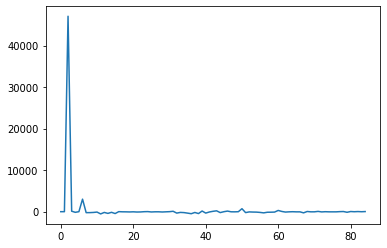

In [52]:
params = param_config[sensor_num]

result = [] 
src_img = imread(img_list[0])

for img_path in tqdm(img_list): 
    dest_img = imread(img_path)
    result.append(convert_by_img(dest_img,
                                 src_img,
                                 min_rad = params['min_rad'],
                                 max_rad = params['max_rad'],
                                 param1 = params['param1'],
                                 param2 = params['param2'],
                                ))
    
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])
    
plt.plot(np.array(collect_rslt))

In [47]:
## check the circle detection accuracy 

param1 = 200
param2 = 25
min_rad = 77
max_rad = 85
img = imread(img_list[0]) 
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ret3, grey_img = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)



In [48]:
# th3 = 255 - th3

circles = cv2.HoughCircles(grey_img, 
                           cv2.HOUGH_GRADIENT,
                           1, 
                           max_rad*2, 
                           param1=param1,
                           param2=param2,
                           minRadius=min_rad,
                           maxRadius=max_rad)

# Draw circles that are detected. 
if circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
  
    for pt in circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
  
        # Draw the circumference of the circle. 
        cv2.circle(grey_img, (a, b), r, (0, 255, 0), 2) 
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(grey_img, (a, b), 1, (0, 0, 255), 3) 
        cv2.imshow("Detected Circle", grey_img) 
        cv2.waitKey(0) 
else:
        cv2.imshow('Circle is not detected', grey_img)
        cv2.waitKey(0) 